# Correlations and linear models
A linear model estimate a response from the linear combination of one or more inputs

$y \approx x_1 \alpha_1 + y_2 \alpha_2 + ... + y_n \alpha_n$

$y \approx \vec{x} \cdot \vec{\alpha}$

given an estimation $\hat{y} = \vec{x} \cdot \vec{\alpha}$

we look for the best $\vec{\alpha}$ which minimize all residuals $\epsilon(\hat{y}) = y - \hat{y}$

In [1]:
import pandas as pd

This dataset collects the yearly water and energy consuption estimation per capita in Milan collected by the italian government

Data is grouped by 

- water consumption
- methan consumption
- electricity consumption

In [2]:
cons = pd.read_csv("ds523_consumoacquaenergia.csv",sep=";")

In [3]:
cons.describe(include="all")

,anno,Consumo pro capite tipo,Consumo pro capite
count,36.00000,36,36.000000
unique,NaN,3,NaN
top,NaN,Energia elettrica per uso domestico,NaN
freq,NaN,12,NaN
mean,2005.50000,NaN,573.072222
std,3.50102,NaN,471.777743
min,2000.00000,NaN,80.400000
25%,2002.75000,NaN,89.625000
50%,2005.50000,NaN,432.900000
75%,2008.25000,NaN,1195.650000


In [4]:
cons["Consumo pro capite tipo"].unique()

array(['Energia elettrica per uso domestico',
       'Gas metano per uso domestico e riscaldamento',
       'Acqua fatturata per uso domestico'], dtype=object)

In [5]:
translate = {
    'Energia elettrica per uso domestico':'electricity',
    'Gas metano per uso domestico e riscaldamento':'methan',
    'Acqua fatturata per uso domestico':'water'
}
cons["type"] = cons["Consumo pro capite tipo"].map(translate)

In [6]:
cons2 = cons.pivot(index="anno",columns="type",values="Consumo pro capite").reset_index()
cons2 = cons2.rename({"anno":"year"}, axis="columns")
cons2

type,year,electricity,methan,water
0,2000,1130.2,509.0,92.1
1,2001,1143.9,500.7,91.3
2,2002,1195.5,504.2,90.4
3,2003,1222.8,480.2,87.3
4,2004,1228.6,442.4,80.4
5,2005,1225.0,434.5,81.3
6,2006,1219.7,431.3,82.2
7,2007,1197.0,381.1,81.6
8,2008,1203.0,384.9,84.5
9,2009,1202.9,389.6,85.8


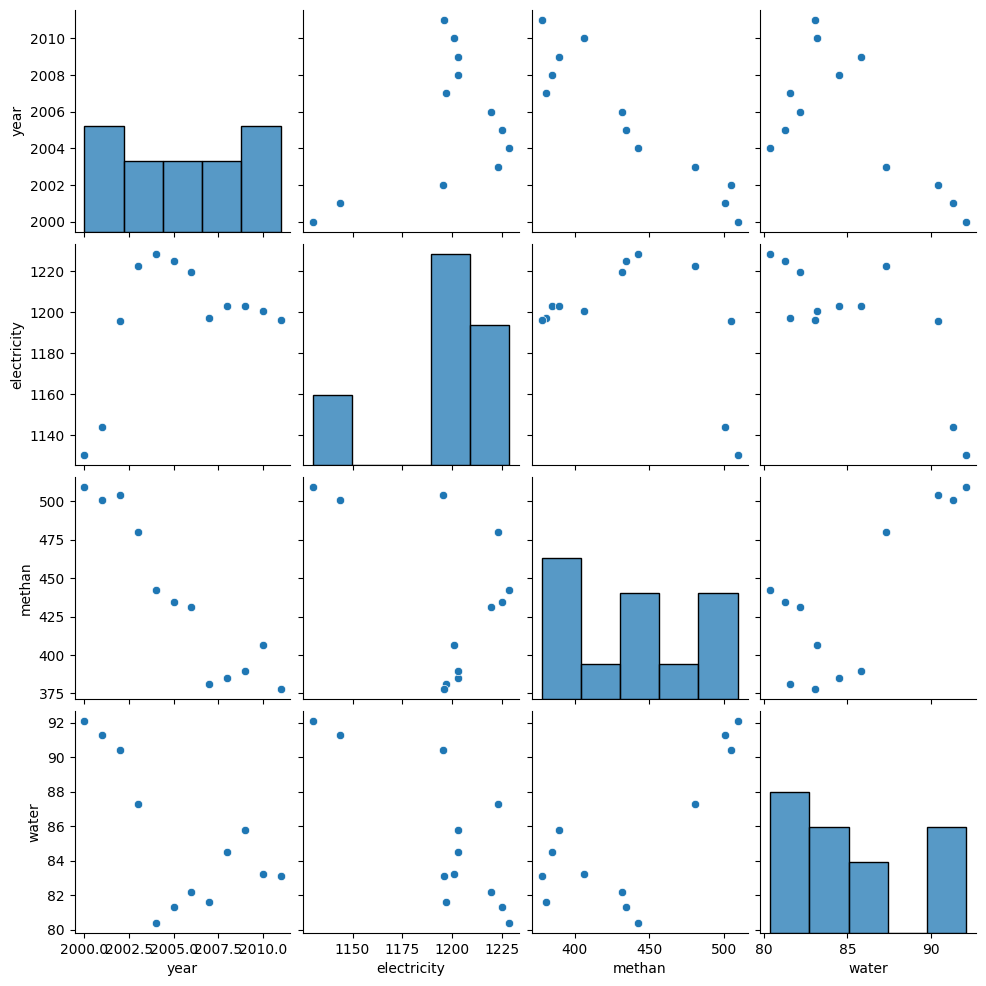

In [8]:
import seaborn as sns
sns.pairplot(cons2)

<Axes: xlabel='year', ylabel='methan'>

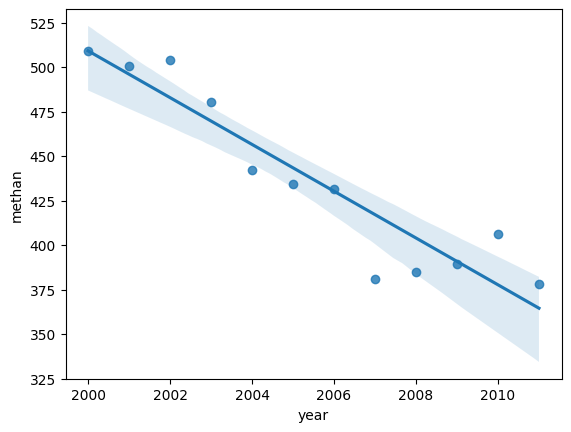

In [12]:
sns.regplot(cons2,x="year",y="methan")

## Covariance and correlation

The [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix), defined as

$cov[X_i, X_j] = E[(X_i - E[X_i])(X_j - E[X_j])]$

is the multidimensional extension of the variance, elements of the diagonal being the variance of the corrisponding dimension; its eigenvectors define an ellipsoid representing the most important combinations of the dimensional features; this is used in Principal Compaonent Analysis, a technique which helps to define the most impactful features.

By dividing each element with the product of the standard deviations we have the [correlation matrix](https://en.wikipedia.org/wiki/Correlation)

$corr[X_i, X_j] = \frac{E[(X_i - E[X_i])(X_j - E[X_j])]}{\sigma_i\sigma_j}$

The elements outside the diagonal are numbers between -1 and 1; 0 represents no correlation (like a spherical cloud) while 1 and -1 represent positive and negative correlation respectively; this gives us a first estimation of the possible linear dependecies within a set of observation features

In [17]:
import numpy as np
# numpy expects a matrix where each feature is in a row instead of a column
# thus we need to transpose it
np.corrcoef(np.transpose(np.array(cons2)))

array([[ 1.        ,  0.44786015, -0.93548315, -0.65540971],
       [ 0.44786015,  1.        , -0.46029677, -0.77514369],
       [-0.93548315, -0.46029677,  1.        ,  0.75208366],
       [-0.65540971, -0.77514369,  0.75208366,  1.        ]])

we can see that the negative correlation between year and methan is about -0.9 which makes it a good candidate for a linear correlation

In [18]:
from scipy import stats

## Regression calculation
in this simple case we have 
- few observations
- only one input value
so we may directly use the [Ordinary Least Squares regression method](https://en.wikipedia.org/wiki/Ordinary_least_squares) to evaluate the best fit

In [19]:
result = stats.linregress(x=cons2.year, y=cons2.methan)
result

LinregressResult(slope=np.float64(-13.141258741258738), intercept=np.float64(26791.62773892773), rvalue=np.float64(-0.9354831530794605), pvalue=np.float64(7.894692952340761e-06), stderr=np.float64(1.5697563928623894), intercept_stderr=np.float64(3148.151109622701))

the returned object contains some interesting values; let's check the first two:
- slope
- intercept
  
allows us to write a simple prediction formula

In [27]:
def predict_methan(year):
    return result.slope * year + result.intercept


with this formula we can build a chart of our linear regression

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

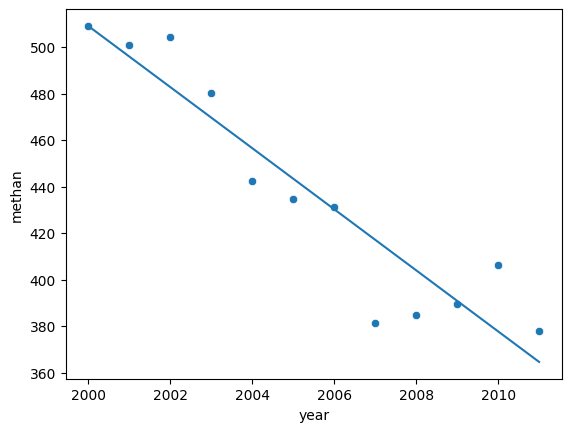

In [32]:
# create a plot canvas
fig, ax = plt.subplots(1,1)

#first plot the points into our canvas
sns.scatterplot(x=cons2.year, y=cons2.methan, ax=ax)

# then plot a line from the first to the last point on the same canvas
year0 = min(cons2.year)
year1 = max(cons2.year)
ax.plot((year0,year1),(predict_methan(year0),predict_methan(year1)))

note: the polymorphism allows to properly use the prodict_methan function also with pandas Series

## Assessing the qaulity of a regression

In [30]:
residuals = cons2.methan - predict_methan(cons2.year)

looking at residuals distribution may show some pattern; in this case we may assume there is a better way to represent the relation between the features under investigation.

In our example looks like there is no apparent pattern

<Axes: xlabel='year', ylabel='None'>

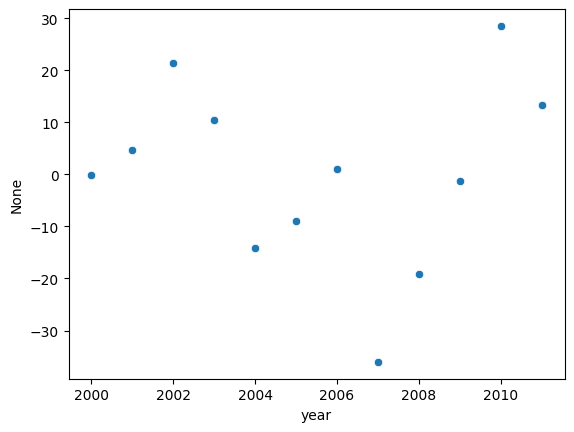

In [31]:
sns.scatterplot(x=cons2.year, y=residuals)

The next step would be to assess the variance of residuals respect to the total variance of the distribution of the output variable Y:

\begin{equation}
\frac{var[\epsilon]}{var[Y]} = \frac{E[(\epsilon - E[\epsilon])^2]}{E[(Y - E[Y])^2]}
\end{equation}

let's use $\hat{Y}$ to represent the predicted values;
by knowing that the mean of the residuals is 0 and their definition 

\begin{equation}
E[\epsilon] = 0
\end{equation}

\begin{equation}
\epsilon = Y - \hat{Y}
\end{equation}

we have

\begin{equation}
\frac{var[\epsilon]}{var[Y]} = \frac{E[(Y - \hat{Y})^2]}{E[(Y - E[Y])^2]}
\end{equation}

now the quantity

\begin{equation}
R^2 = 1 - \frac{E[(Y - \hat{Y})^2]}{E[(Y - E[Y])^2]}
\end{equation}

represent the fraction of the variance of the original dataset explained by the linear relation: this is a real number between 0 and 1 where 0 represents no actual explaination (i.e. the mean has the same prediction power) to 1 representing all the relation is explained